# Imports

In [1088]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm

%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer


from collections import Counter

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re

In [1089]:
df_raw = pd.read_csv('survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


In [1090]:
df_raw.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

# Cleaning

## Dropping Unimportant Columans

In [1091]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop

In [1092]:

df_drop.dropna(inplace=True)
# df_drop.Country.unique()


asian_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 'Sri Lanka',
                   'Georgia', 'Hong Kong (S.A.R.)', 'Japan', 'United Arab Emirates', 
                   'Turkey', 'Pakistan', 'Lebanon', 'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                   'Syrian Arab Republic', 'Taiwan', 'South Korea', 'Viet Nam', 
                   "Lao People's Democratic Republic", 'Nepal', 'Philippines', 'Azerbaijan', 
                   'Saudi Arabia', 'Singapore', 'Armenia', 'Cyprus', 'Kuwait', 'Thailand', 
                   'Myanmar', 'Kazakhstan', 'Iraq', 'Bahrain', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 
                   'Republic of Korea', 'Tajikistan', 'Oman', 'Palestine', 'Afghanistan', 'Mongolia', 'Maldives',
                   'Qatar', 'Turkmenistan'
                  ]

df_drop = df_drop[df_drop['Country'].isin(asian_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83355,83356,I am a developer by profession,Employed full-time,Japan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,3,"Developer, front-end;Developer, desktop or ent...",20 to 99 employees,C#;HTML/CSS;JavaScript;SQL;TypeScript,Microsoft SQL Server,AWS,Windows,Less than once per month or monthly,35-44 years old,450.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0
83402,83403,I am a developer by profession,Employed full-time,South Korea,"Secondary school (e.g. American high school, G...",4,Less than 1 year,"Developer, mobile;Developer, front-end;Develop...",2 to 9 employees,C;Dart;HTML/CSS;Java;JavaScript;Kotlin;Node.js,Firebase;MariaDB;MongoDB;MySQL;Oracle,AWS;Heroku,MacOS,I have never participated in Q&A on Stack Over...,18-24 years old,18708.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,5,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0


In [1093]:
data_dev_list = ['Data scientist or machine learning specialist', 'Database administrator', 'Data or business analyst', 'Engineer, data']
ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
213,214,I am a developer by profession,Employed full-time,Russian Federation,"Other doctoral degree (Ph.D., Ed.D., etc.)",15,9,"Developer, mobile;Developer, full-stack;Data s...","10,000 or more employees",C#;Java;Python,PostgreSQL,Google Cloud Platform,Windows,A few times per month or weekly,25-34 years old,75492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,11,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,2,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15,13,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


In [1094]:
# OHE_list = []
# ordinal_list = []
# for col in df_asia.columns:
#     print(col, '\n--------------')
#     display(df_asia[col].unique())
#     ans = input('action')
#     if ans == 'cat':
#         OHE_list.append(col)
#     elif ans == 'ord':
#         ordinal_list.append(col)

In [1095]:
OHE_list = ['Employment', 'Country', 'OpSys', 'Age']

In [1096]:
ordinal_list = ['MainBranch', 'EdLevel', 'OrgSize', 'SOPartFreq']

**Columns that need transformation**

In [1097]:
df_devs[df_devs.columns.difference(OHE_list+ordinal_list)].head()

,ConvertedCompYearly,DatabaseHaveWorkedWith,DevType,LanguageHaveWorkedWith,PlatformHaveWorkedWith,ResponseId,YearsCode,YearsCodePro
58,22644.0,Oracle,"Developer, full-stack;Data scientist or machin...",Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Heroku,59,5,3
148,36000.0,SQLite,Database administrator;Data or business analyst,SQL,Google Cloud Platform,149,2,2
154,2340.0,Firebase;MariaDB;MongoDB;MySQL;Redis,"Developer, front-end;Developer, full-stack;Dev...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Heroku,155,20,7
168,14844.0,SQLite,"Developer, front-end;Engineer, data;Developer,...",HTML/CSS;JavaScript;Python;SQL,DigitalOcean;Heroku,169,4,2
213,75492.0,PostgreSQL,"Developer, mobile;Developer, full-stack;Data s...",C#;Java;Python,Google Cloud Platform,214,15,9


## Prepping Features with top X filtering

In [1098]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [1099]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 12, 'Lang')
lang_OHE

,Lang_SQL,Lang_Python,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,Lang_C#,Lang_Bash/Shell,Lang_C++,Lang_TypeScript,Lang_C
index,,,,,,,,,,,,
58,1,1,1,1,0,0,0,0,1,0,0,0
148,1,0,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,0,1,1,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,0,0
213,0,1,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,1,0,0,1,0,1,0,0,0
83291,1,1,0,1,1,0,0,0,0,0,0,1
83294,0,0,0,0,0,1,1,0,0,0,0,0


In [1100]:
devtype_OHE = OHE_semicolon_vals('DevType', 10, 'Dev')
devtype_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,"Dev_Engineer, data",Dev_Data scientist or machine learning specialist,"Dev_Developer, front-end",Dev_Data or business analyst,Dev_System administrator,"Dev_Developer, desktop or enterprise applications","Dev_Developer, mobile"
index,,,,,,,,,,
58,0,1,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0
154,1,1,1,0,0,1,0,1,0,0
168,1,0,0,1,0,1,0,0,0,0
213,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,1,0,0
83291,0,0,0,1,0,0,1,0,0,0
83294,1,0,1,0,0,0,0,0,0,0


In [1101]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 10, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_MongoDB,DB_SQLite,DB_Redis,DB_Microsoft SQL Server,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle
index,,,,,,,,,,
58,0,0,0,0,0,0,0,0,0,1
148,0,0,0,1,0,0,0,0,0,0
154,1,0,1,0,1,0,1,1,0,0
168,0,0,0,1,0,0,0,0,0,0
213,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83046,0,0,0,1,1,0,1,0,1,0
83291,1,0,0,1,0,1,0,0,0,1
83294,1,1,0,1,0,0,1,0,0,0


In [1102]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 10, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,
58,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0
154,0,0,0,0,1,0,0
168,0,0,0,1,1,0,0
213,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
83046,1,0,0,1,0,0,0
83291,0,1,0,0,0,0,0
83294,0,1,0,0,0,0,0


Changing `YearsCode` and `YearsCodeProd` to numeric

In [1103]:
df_devs['YearsCode']

58        5
148       2
154      20
168       4
213      15
         ..
83046    14
83291     5
83294    15
83356    11
83431     9
Name: YearsCode, Length: 966, dtype: object

In [1104]:
#YearsCode
def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    else:
        return int(x)

df_devs['YearsCode'] = df_devs['YearsCode'].copy().apply(years_code_mapping)
#YearsCodePro
df_devs['YearsCodePro'] = df_devs['YearsCodePro'].copy().apply(years_code_mapping)


## Ordinal Mapping 

In [1105]:
df_devs['MainBranch'].unique()

array(['I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession'], dtype=object)

In [1106]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [1107]:
len(df_devs['EdLevel'].unique())

9

In [1108]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)
# df_asia
# df_asia['EdLevel']

In [1109]:
len(df_devs['OrgSize'].unique())

10

In [1110]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [1111]:
len(df_devs['SOPartFreq'].unique())

6

In [1112]:
df_devs['SOPartFreq'].unique()

SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

In [1113]:
df_devs[ordinal_list]

,MainBranch,EdLevel,OrgSize,SOPartFreq
58,0,8,4,1
148,0,6,1,5
154,1,5,1,4
168,1,3,1,4
213,1,7,9,2
...,...,...,...,...
83046,0,6,4,4
83291,1,5,9,3
83294,1,3,4,0
83356,1,5,1,0


## OHE

In [1114]:
df_devs[OHE_list]

,Employment,Country,OpSys,Age
58,Employed full-time,Russian Federation,Linux-based,25-34 years old
148,"Independent contractor, freelancer, or self-em...",Sri Lanka,Windows,25-34 years old
154,"Independent contractor, freelancer, or self-em...",India,Windows,25-34 years old
168,"Independent contractor, freelancer, or self-em...",Georgia,Linux-based,18-24 years old
213,Employed full-time,Russian Federation,Windows,25-34 years old
...,...,...,...,...
83046,Employed full-time,India,MacOS,25-34 years old
83291,Employed full-time,India,Windows,18-24 years old
83294,Employed full-time,Russian Federation,Windows,25-34 years old
83356,"Independent contractor, freelancer, or self-em...",Indonesia,Windows Subsystem for Linux (WSL),25-34 years old


In [1115]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)
numeric_data = df_devs.select_dtypes(['int', 'float'])
numeric_data.index.name='index'
numeric_data

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly
index,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644
148,149,0,6,2.0,2.0,1,5,36000
154,155,1,5,20.0,7.0,1,4,2340
168,169,1,3,4.0,2.0,1,4,14844
213,214,1,7,15.0,9.0,9,2,75492
...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962
83291,83292,1,5,5.0,2.0,9,3,5026
83294,83295,1,3,15.0,13.0,4,0,30192


In [1116]:
OHE_data = pd.concat([lang_OHE,database_OHE, devtype_OHE, platform_OHE, pd.get_dummies(df_devs[OHE_list])], axis=1)
df_final = pd.merge(left=numeric_data, right=OHE_data, left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644,1,1,...,0,0,0,0,1,0,0,0,0,0
148,149,0,6,2.0,2.0,1,5,36000,1,0,...,0,1,0,0,1,0,0,0,0,0
154,155,1,5,20.0,7.0,1,4,2340,1,1,...,0,1,0,0,1,0,0,0,0,0
168,169,1,3,4.0,2.0,1,4,14844,1,1,...,0,0,0,1,0,0,0,0,0,0
213,214,1,7,15.0,9.0,9,2,75492,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962,1,0,...,0,0,0,0,1,0,0,0,0,0
83291,83292,1,5,5.0,2.0,9,3,5026,1,1,...,0,1,0,1,0,0,0,0,0,0
83294,83295,1,3,15.0,13.0,4,0,30192,0,0,...,0,1,0,0,1,0,0,0,0,0


# EDA

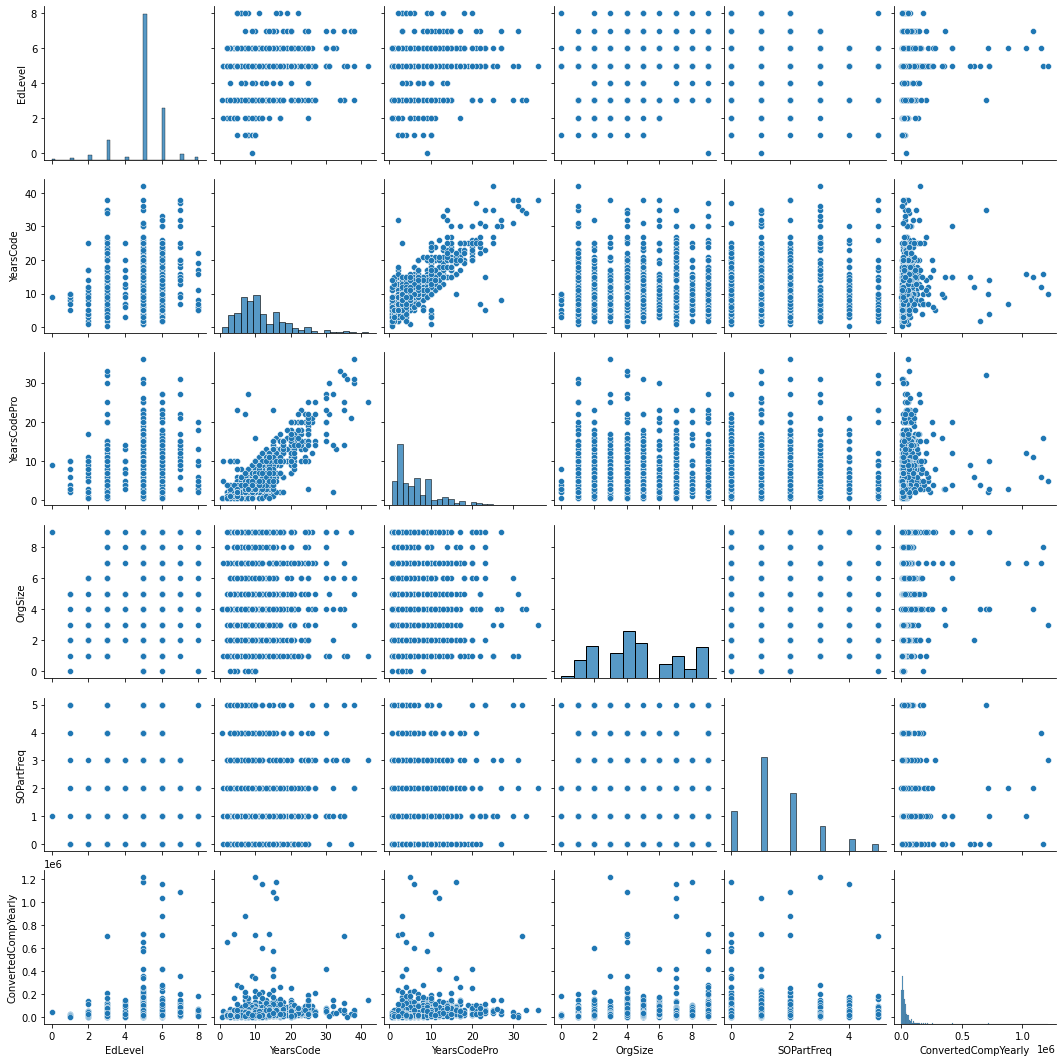

In [1117]:
sns.pairplot(data=df_final[['EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'SOPartFreq', 'ConvertedCompYearly']], diag_kind='hist')
plt.show()

Skewed features may need log transformation to improve model results. idk yet will initially try running models on not transformed data

<AxesSubplot:ylabel='Frequency'>

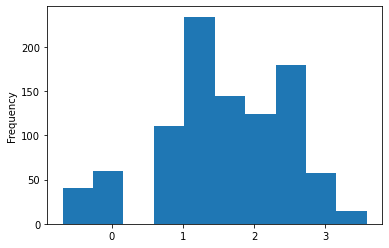

In [1118]:
df_final['YearsCodePro'] = df_final['YearsCodePro'].copy().apply(np.log)
df_final['YearsCodePro'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

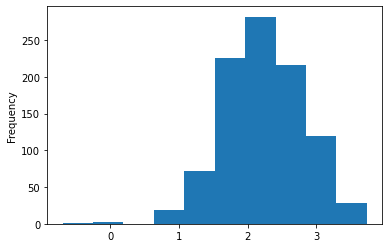

In [1119]:
df_final['YearsCode'] = df_final['YearsCode'].copy().apply(np.log)
df_final['YearsCode'].plot(kind='hist')

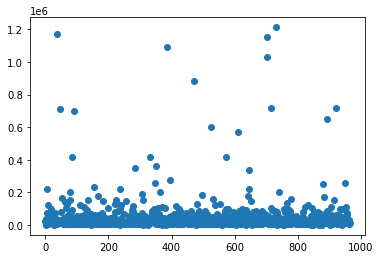

In [1120]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

In [1121]:
idx_outliers_y = df_final['ConvertedCompYearly'].sort_values(ascending=False).head(10).index.to_list()
display(df_final.loc[idx_outliers_y,:].iloc[:,5:])

,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,...,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old
index,,,,,,,,,,,,,,,,,,,,,
64387,3,3,1212996,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3640,8,0,1172784,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
61320,7,4,1153104,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33008,4,2,1089012,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
61284,7,1,1032708,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
40419,7,2,881305,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
78563,4,1,720000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
62890,9,0,719433,1,1,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4507,4,2,713448,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [1122]:
df_final = df_final.drop(idx_outliers_y, axis=0)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,1,1,...,0,0,0,0,1,0,0,0,0,0
148,149,0,6,0.693147,0.693147,1,5,36000,1,0,...,0,1,0,0,1,0,0,0,0,0
154,155,1,5,2.995732,1.945910,1,4,2340,1,1,...,0,1,0,0,1,0,0,0,0,0
168,169,1,3,1.386294,0.693147,1,4,14844,1,1,...,0,0,0,1,0,0,0,0,0,0
213,214,1,7,2.708050,2.197225,9,2,75492,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,1,0,...,0,0,0,0,1,0,0,0,0,0
83291,83292,1,5,1.609438,0.693147,9,3,5026,1,1,...,0,1,0,1,0,0,0,0,0,0
83294,83295,1,3,2.708050,2.564949,4,0,30192,0,0,...,0,1,0,0,1,0,0,0,0,0


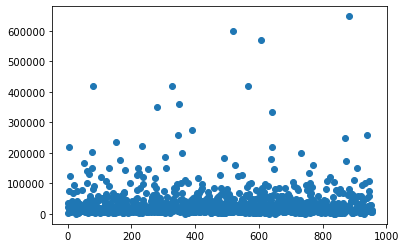

In [1123]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

# Adding language counts as a feature

In [1124]:
def filter_lang(prefix):
    li = []
    for elem in df_final.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_final['LCount'] = df_final[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_final['DCount'] = df_final[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_final['PCount'] = df_final[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_final['DbCount'] = df_final[db_cols].sum(axis=1)


# country_cols = filter_lang('Country_')
country_cols = []
# df_final = df_final.drop(
#     lang_cols+dev_cols+plat_cols+db_cols+country_cols, axis=1
# )

df_final = df_final.drop(
    dev_cols+plat_cols+db_cols+country_cols, axis=1
)

df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,LCount,DCount,PCount,DbCount
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,1,1,...,1,0,0,0,0,0,5,2,1,1
148,149,0,6,0.693147,0.693147,1,5,36000,1,0,...,1,0,0,0,0,0,1,2,1,1
154,155,1,5,2.995732,1.945910,1,4,2340,1,1,...,1,0,0,0,0,0,6,5,1,5
168,169,1,3,1.386294,0.693147,1,4,14844,1,1,...,0,0,0,0,0,0,4,3,2,1
213,214,1,7,2.708050,2.197225,9,2,75492,0,1,...,1,0,0,0,0,0,3,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,1,0,...,1,0,0,0,0,0,4,5,2,4
83291,83292,1,5,1.609438,0.693147,9,3,5026,1,1,...,0,0,0,0,0,0,5,2,1,4
83294,83295,1,3,2.708050,2.564949,4,0,30192,0,0,...,1,0,0,0,0,0,2,2,1,4


# ML

In [1125]:
X = df_final[df_final.columns.difference(['ConvertedCompYearly', 'ResponseId'])]
y = df_final['ConvertedCompYearly']

In [1126]:
# y = y.apply(np.log)
y.sort_values(ascending=False)

index
75945    647484
44346    600000
53072    569640
47843    418852
9482     418848
          ...  
54565       709
2646        698
65141       648
71886       612
80806        56
Name: ConvertedCompYearly, Length: 956, dtype: int32

## Logged y

since y is initially skewed

In [1127]:

y = np.log(y)
y

index
58       10.027650
148      10.491274
154       7.757906
168       9.605351
213      11.231782
           ...    
83046     9.544095
83291     8.522380
83294    10.315332
83356     8.856518
83431     9.365291
Name: ConvertedCompYearly, Length: 956, dtype: float64

## Train-Test Split

In [1128]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

## CV

In [1129]:
# from sklearn.ensemble import RandomForestRegressor

# rf_test = RandomForestRegressor()
# rf_test.fit(X_trainval, y_trainval)
# rf_test_pred = rf_test.predict(X_holdout)
# mean_absolute_error(y_holdout, rf_test_pred)

In [1130]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,15)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]])
        
        # cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
        cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(median_absolute_error))
        
        # cr_val = cross_val_score(model, X, y, cv=5, scoring='r2')
        return np.mean(cr_val)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=50, n_jobs=4)
    return study, optimize

In [1131]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-11-25 23:57:55,561] A new study created in memory with name: no-name-6da0fdf1-3f11-4810-a1b9-169a69115467
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-11-25 23:57:58,657] Trial 1 finished with value: 0.5155473862493704 and parameters: {'n_estimators': 90, 'max_depth': 12, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5155473862493704.
[I 2021-11-25 23:57:59,839] Trial 2 finished with value: 0.5590668943000191 and parameters: {'n_estimators': 250, 'max_depth': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.5155473862493704.
[I 2021-11-25 23:58:00,569] Trial 5 finished with value: 0.5372611230754307 and parameters: {'n_estimators': 30, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5155473862493704.
[I 2021-11-25 23:58:01,833] Trial 6 finished with value: 0.576105026159939 and parameters: {'n_estimators': 80, 'max_depth': 5, 'ma

In [1132]:
rf_study.best_params

{'n_estimators': 480, 'max_depth': 13, 'max_features': 'sqrt'}

In [1133]:
rf = RandomForestRegressor(**rf_study.best_params)
rf.fit(X_trainval, y_trainval)
rf_pred = rf.predict(X_holdout)

# mean_absolute_error(np.exp(y_holdout), np.exp(rf_pred)) # 29278.242137076086 if outliers are not removed

# without outliers

# 


# log transformed yearscodepro and yearscode

#######
median_absolute_error(np.exp(y_holdout), np.exp(rf_pred))

9824.595703787469

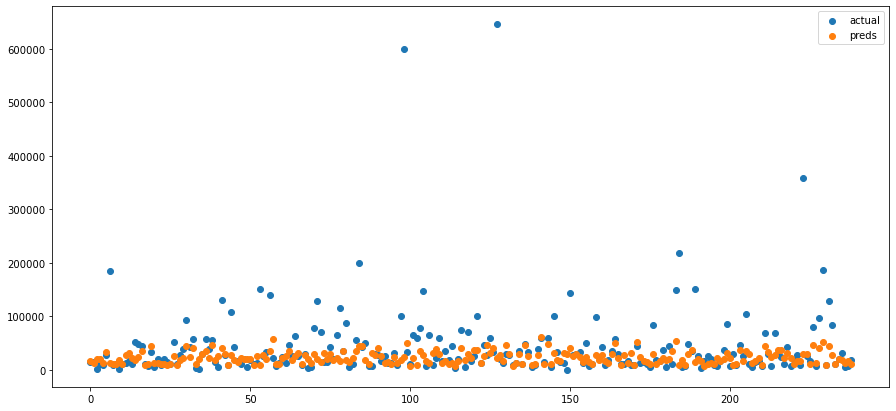

In [1134]:
y_holdout_plot = y_holdout.reset_index().drop(columns='index', axis=0)


fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(y_holdout_plot.index, np.exp(y_holdout_plot), label='actual')
plt.scatter(y_holdout_plot.index, np.exp(rf_pred), label='preds')
plt.legend()
# plt.ylim(0, 400000)

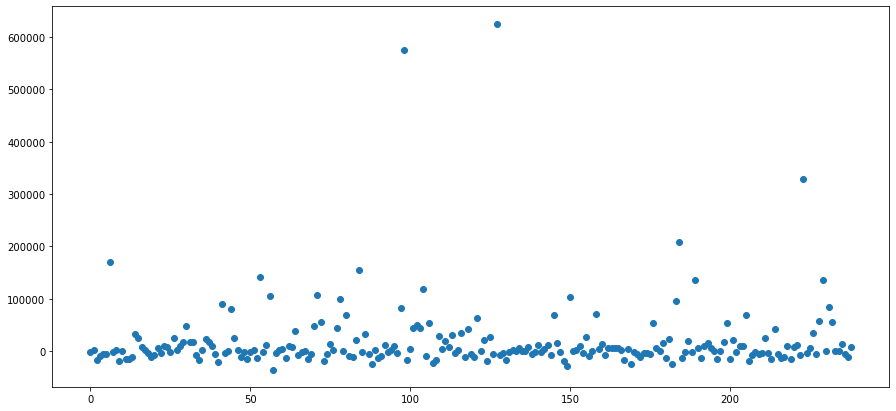

In [1135]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(range(len(rf_pred)), np.exp(y_holdout) - np.exp(rf_pred))

In [1136]:
np.exp(y_holdout) - np.exp(rf_pred)

index
31173    -1344.398550
45311     1257.717270
50389   -17932.970137
37638    -9606.310870
25328    -4887.921990
             ...     
75787     -125.145453
45198    12758.017554
16748    -6326.133850
13322   -10368.714713
45761     7531.417852
Name: ConvertedCompYearly, Length: 239, dtype: float64

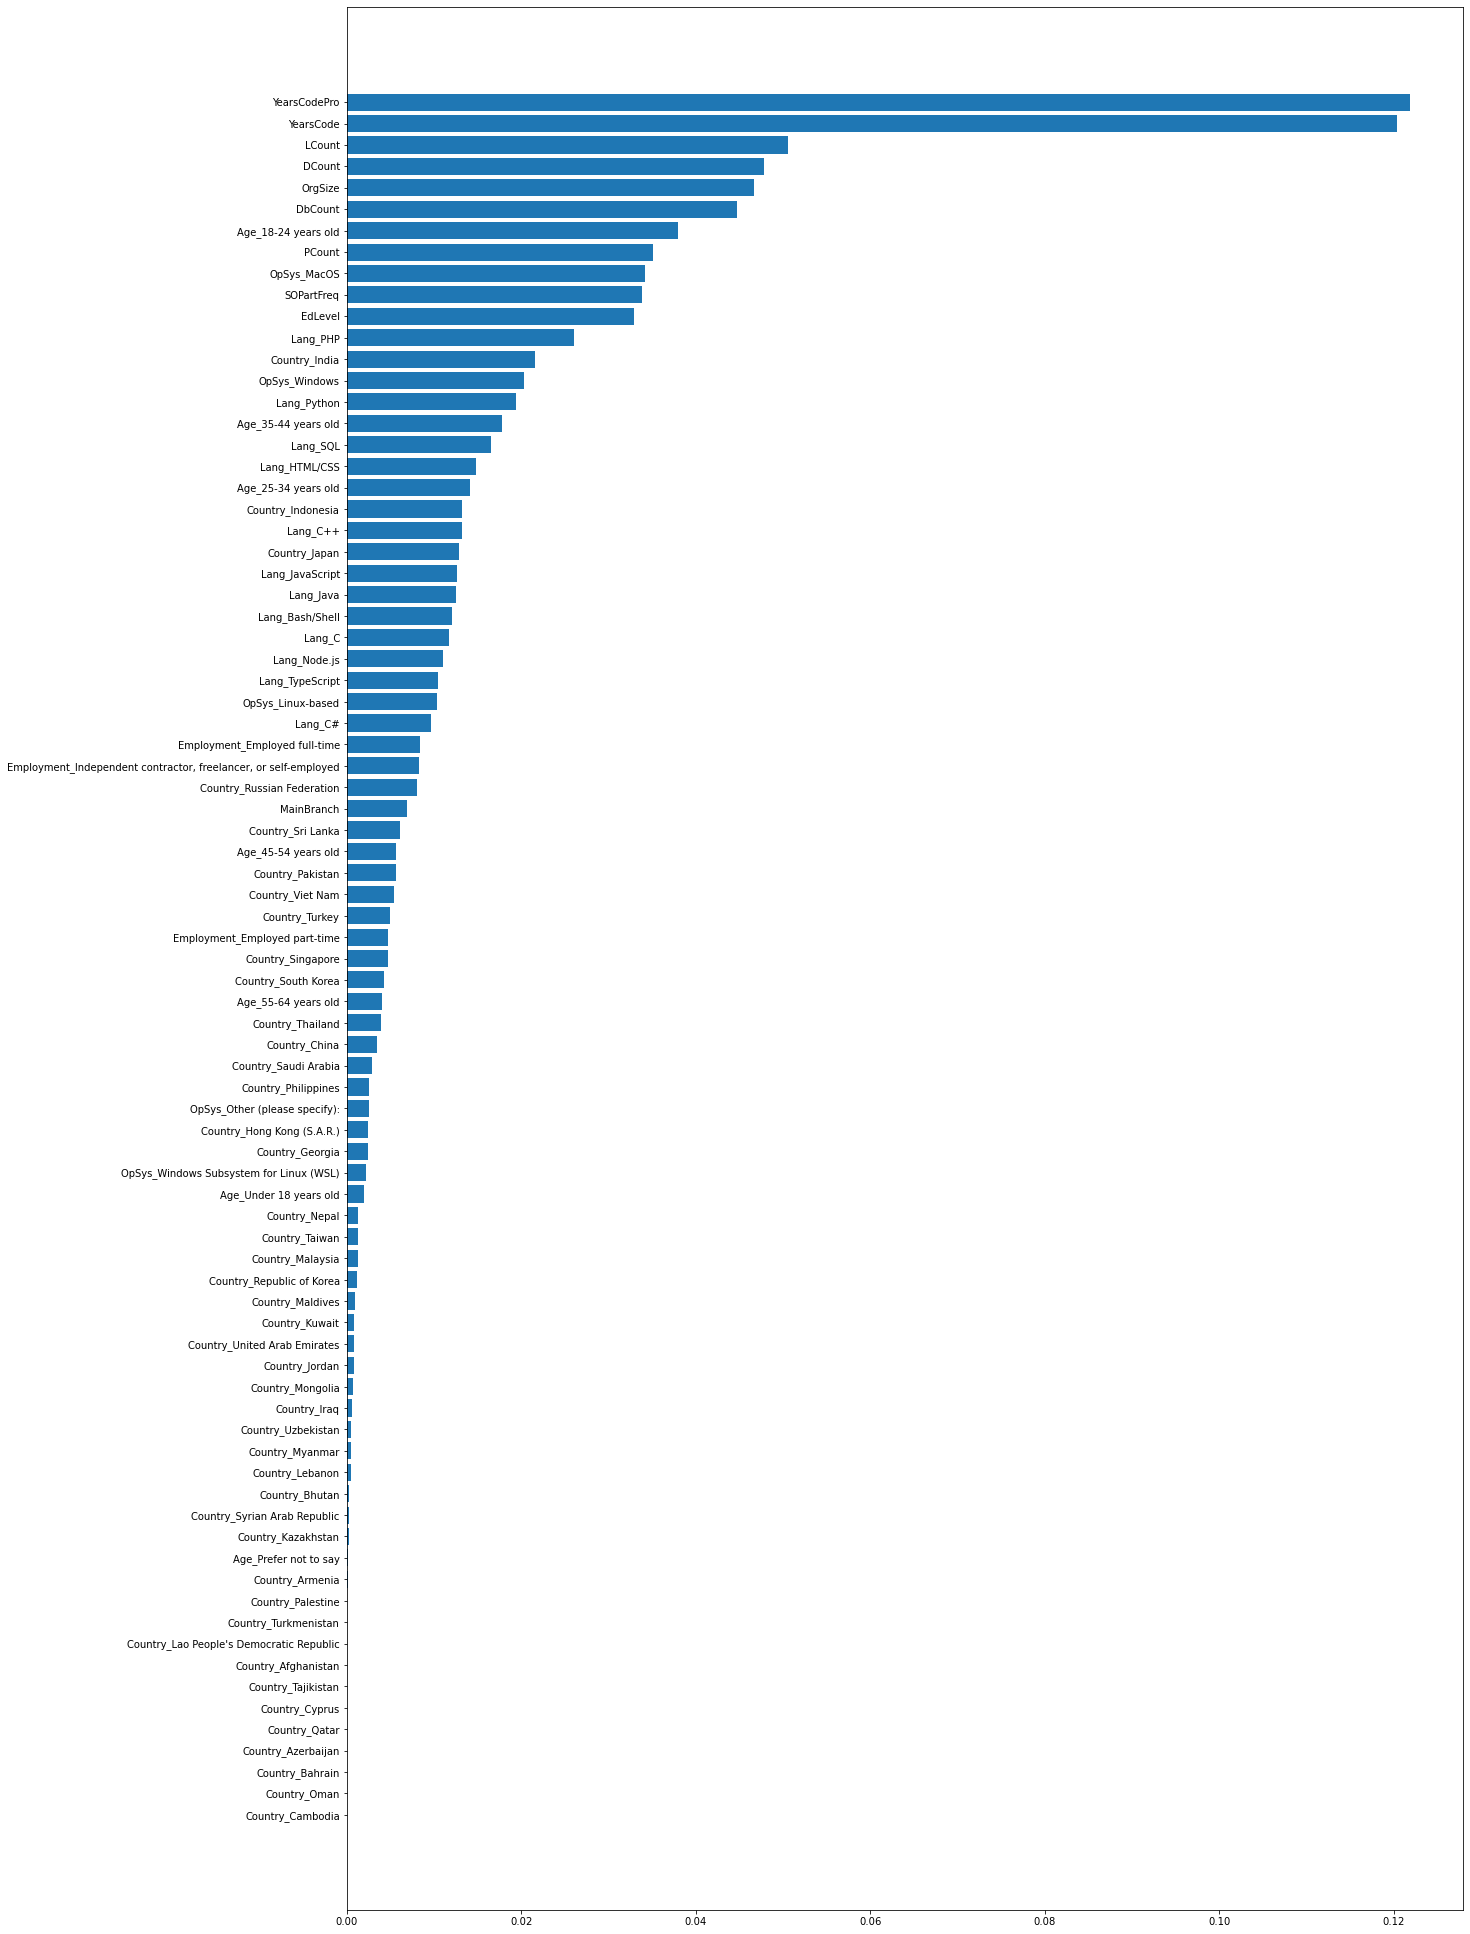

In [1137]:
fig, ax = plt.subplots(figsize=(20,35))
plt.barh(X.columns[rf.feature_importances_.argsort()], rf.feature_importances_[rf.feature_importances_.argsort()])
# plt.autoscale()
plt.savefig('rf_feat_imp')

In [1138]:
rf.feature_importances_

array([3.79464701e-02, 1.40832646e-02, 1.77538975e-02, 5.64053908e-03,
       4.06262174e-03, 1.33340221e-04, 1.98624940e-03, 3.66708588e-05,
       1.16770058e-04, 0.00000000e+00, 0.00000000e+00, 2.80450724e-04,
       0.00000000e+00, 3.49215236e-03, 1.99832014e-05, 2.38254843e-03,
       2.40343475e-03, 2.15501171e-02, 1.31767054e-02, 5.50343958e-04,
       1.28366957e-02, 8.07977574e-04, 2.01747762e-04, 8.67223324e-04,
       3.69245327e-05, 4.51133302e-04, 1.22548251e-03, 8.80264239e-04,
       7.13798469e-04, 4.80480040e-04, 1.33748566e-03, 0.00000000e+00,
       5.59486167e-03, 5.73310358e-05, 2.57183271e-03, 1.44340804e-05,
       1.14997336e-03, 8.08336357e-03, 2.87069365e-03, 4.75620533e-03,
       4.29848067e-03, 6.03947961e-03, 2.16885256e-04, 1.23612605e-03,
       3.02427346e-05, 3.87393680e-03, 4.96616824e-03, 5.41895076e-05,
       8.20090415e-04, 5.27798857e-04, 5.39280883e-03, 4.77707389e-02,
       4.47811195e-02, 3.29290018e-02, 8.44042123e-03, 4.76340990e-03,
      